# <a id='toc1_'></a>[Домашняя-зачетная работа](#toc0_)

Студент: **Королев Федор Александрович**

Команда: **7**

Будем создавать модель для определения, что находится на фотографии человек/животное.

# Установка пакетов

In [ ]:
!pip install torchinfo
!pip install roboflow

# Импорты

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import os
import pandas as pd
import random
import uuid
import time
from torchinfo import summary
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.transforms import v2
from IPython.display import clear_output
import numpy as np
from google.colab import drive

In [ ]:
%matplotlib inline

# Загрузка датасета

In [ ]:
# Датасет взят с https://universe.roboflow.com/ml-4aree/animalhuman/dataset/1

from roboflow import Roboflow
from google.colab import userdata

API_KEY = userdata.get('ROBOFLOW_API_KEY')

rf = Roboflow(api_key=API_KEY)
project = rf.workspace("ml-4aree").project("animalhuman")
version = project.version(1)
dataset = version.download("multiclass")


## Не требует запуска: Вычисление mean и std

По совету нейросети вычисляем mean и std, для нашего датасета, чтобы потом ипользовать их в transforms

In [ ]:
data = ImageFolder(root=dataset.location, transform=transforms.ToTensor())

mean = torch.zeros(3)
std = torch.zeros(3)

for img, _ in data:
    mean += torch.mean(img, dim=[1,2])
    std += torch.std(img, dim=[1,2])

mean /= len(data)
std /= len(data)

print('Mean:', mean)
print('Std:', std)

# Основная секция

## Подготовка датасета

Класс датасета

In [ ]:
class WorkDataset(Dataset):
    def __init__(self, data_path, labels, input_channels=3, transform=None):
        self.data_path = data_path
        self.labels = labels
        self.transform = transform
        self.input_channels = input_channels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        img_name = self.labels.iloc[index, 0]
        img_path = os.path.join(self.data_path, img_name)
        img = Image.open(img_path)

        label = self.labels.iloc[index, 1]

        if self.input_channels == 3:
            img = img.convert('RGB')
        else:
            img = img.convert('L')

        if self.transform:
            img = self.transform(img)

        return img, label

Функции загрузки датасета

In [ ]:
def load_data(data_path, transform=None, input_channels=3):
    path =  os.path.dirname(os.path.abspath(data_path))
    labels = pd.read_csv(data_path + '/_classes.csv', sep=', ', engine='python')
    # В файле _classes.csv находятся метки. Просмотрел его, оказалось у фотографий может быть только одна метка
    # Поэтому создаем новый DataFrame, где 1 - это человек, 0 - это животное
    labels = pd.DataFrame({"filename": labels['filename'], 'human': labels['human']})
    dataset = WorkDataset(data_path, labels, input_channels, transform)

    return dataset

def load(dataset_path, train_transform=None, val_transform=None, input_channels=3):
    return (load_data(dataset_path + '/train', train_transform, input_channels),
            load_data(dataset_path + '/valid', val_transform, input_channels))

## Модель

Архитектура модели взята с [туториала](https://www.kaggle.com/code/basu369victor/pytorch-tutorial-the-classification) ¯\\_(ツ)_/¯

Пробуем в ней разобраться:

1) Вход 224px\*224px\*3ch = 150528

2) Conv2d - [вот](https://ru.wikipedia.org/wiki/%D0%A1%D0%B2%D1%91%D1%80%D1%82%D0%BE%D1%87%D0%BD%D0%B0%D1%8F_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D0%B0%D1%8F_%D1%81%D0%B5%D1%82%D1%8C#%D0%A1%D0%BB%D0%BE%D0%B9_%D1%81%D0%B2%D1%91%D1%80%D1%82%D0%BA%D0%B8) что можно прочитать про него в википедии, [вот](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) что в документации. Здесь используется ядро 3x3, перемещается оно с шагом 2, так же по краям добавлен отступ 1.

3) [MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) -

4) Dropout - отключает чать нейронов, при обучении

5) [BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) - Слой нормализации

5) Linear - (Fully Connected Layer) Полносвязанный слой, то есть каждый нейрон связан со всеми

6) x.view - Изменяет форму тензора, допустим было 3x2, стало 2x3, в данном случае изменяем форму на одномерный вектор

7) F.log_softmax - Применяем [softmax](https://ru.wikipedia.org/wiki/%D0%9C%D0%BD%D0%BE%D0%B3%D0%BE%D0%BF%D0%B5%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D0%B0%D1%8F_%D0%BB%D0%BE%D0%B3%D0%B8%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D1%84%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D1%8F), которая приводит входные данный в вид вероятностей от 0 до 1, а потом извлекаем из нее логарифм

In [ ]:
class WorkModel(nn.Module):
    def __init__(self):
        super(WorkModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.4)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 2)  # 2 classes: Animal and Human

    def forward(self, x):
        x = self.batchnorm1(F.relu(self.conv1(x)))
        x = self.batchnorm2(F.relu(self.conv2(x)))
        x = self.dropout(self.batchnorm2(self.pool(x)))
        x = self.batchnorm3(self.pool(F.relu(self.conv3(x))))
        x = self.dropout(self.conv4(x))
        x = x.view(x.size(0), -1)
        x = self.dropout(self.fc1(x))
        x = self.dropout(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

## Train/val и accuracy

Следующий класс взят с практики №4, довольно удобный

In [ ]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.cnt = 0
        self.val = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.cnt += n
        self.avg = self.sum / self.cnt

Оценка точности

In [ ]:
def accuracy(out, labels):
    _, pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

Вывод во время обучения

In [ ]:
def output_log(epoch, batch_idx, data_length, loader_dataset_length, loader_length, loss):
    print('Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(
        epoch, batch_idx * data_length, loader_dataset_length,
        100.0 * batch_idx / loader_length, loss))

Функция тренировки

In [ ]:
def train(model, device, train_loader, criterion, optimizer, log=False, epoch=-1, log_interval=20):
    losses = AverageMeter()
    accs = AverageMeter()

    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        # Forward
        output = model(data)
        loss = criterion(output, target)

        acc = accuracy(output, target)

        # Record loss, accuracy
        losses.update(loss.item(), data.size(0))
        accs.update(acc, data.size(0))

        # Backward + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Log
        if log and batch_idx % log_interval == 0:
          output_log(epoch, batch_idx, len(data), len(train_loader.dataset), len(train_loader),
                 loss.item())

    return losses.avg, accs.avg

Валидации

In [ ]:
def val(model, device, val_loader, criterion, log=False, epoch=-1, log_interval=2000):
    losses = AverageMeter()
    accs = AverageMeter()

    model.eval()

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            loss = criterion(output, target)

            acc = accuracy(output, target)

            # Record loss and accuracy
            losses.update(loss.item(), data.size(0))
            accs.update(acc, data.size(0))

            if log and batch_idx % log_interval == 0:
              output_log(epoch, batch_idx, len(data), len(val_loader.dataset), len(val_loader),
                     loss.item())

    return losses.avg, accs.avg

# Инициализация параметров и запуск обучения

In [ ]:
config = {
    'batch_size'    : 64,   # 32 или 64
    'total_epochs'  : 20,   # Поставил 20, но сама модель неплохо обучается за 5
    'save_epoch'    : 3,
    'learning_rate' : 0.001,
    'mean': [0.5067, 0.4707, 0.4144],       # Было вычисленно в разделе "Загрузка датасета"
    'std': [0.2395, 0.2334, 0.2326],
    'data_path': '/content/AnimalHuman-1',
    'save_path': '/content/drive/MyDrive/weights',
    'input_size': 224,
    'input_channels': 3
}

Советы от нейросети

№1 Вы можете начать с 50 или 100 эпох и следить за обучением. Если модель переобучается (то есть ошибка на обучающем наборе продолжает уменьшаться, но ошибка на валидационном наборе начинает увеличиваться), вам может потребоваться остановить обучение раньше.

№ 2 learning_rate: Обычно начинают с 0.001 или 0.0001. Если обучение слишком медленное, вы можете попробовать увеличить скорость обучения. Если обучение нестабильно, вы можете попробовать уменьшить скорость обучения.

### Инициализация начальных состояний

In [ ]:
random_seed = round(time.time() * 1000)
torch.manual_seed(random_seed)
random.seed(random_seed)

### Искажения

In [ ]:
normalize = transforms.Normalize(mean=config['mean'],
                                 std=config['std'])

if config['input_channels'] == 1:
    # Average value
    mean_value = sum(config['mean']) / len(config['mean'])
    std_value = sum(config['std']) / len(config['std'])
    normalize = transforms.Normalize(mean=[mean_value], std=[std_value])

# Такие перевороты предложенны в датасете
class Random90Rotation:
    def __init__(self, angles=[0, 90, 180, 270]):
        self.angles = angles

    def __call__(self, img):
        angle = random.choice(self.angles)
        return v2.functional.rotate(img, angle)

rotate90 = Random90Rotation()

# Взято из примера в датасете
train_transform = v2.Compose([
    rotate90,
    v2.ColorJitter(brightness=0.15, contrast=0.1),
    v2.GaussianBlur(kernel_size=(3, 3)),
    v2.Resize((config['input_size'], config['input_size'])),
    v2.ToTensor(),
    normalize,
])

val_transform = v2.Compose([
    v2.Resize((config['input_size'], config['input_size'])),
    v2.ToTensor(),
    normalize,
])

### Выбор девайса обучения

In [ ]:
use_gpu = False
device = torch.device('cpu')
if torch.cuda.is_available():
    use_gpu = True
    device = torch.device('cuda:0')

print('Device is', device)

Device is cpu


## Загрузка данных

In [ ]:
train_dataset, val_dataset = load(config['data_path'], train_transform, val_transform, config['input_channels'])

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=0,
    pin_memory=use_gpu,
    drop_last=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=0,
    pin_memory=use_gpu,
    drop_last=True
)

print('Train num = {}'.format(len(train_dataset)))
print('Val val = {}'.format(len(val_dataset)))

print('Train batch = {}'.format(len(train_loader)))
print('Val batch = {}'.format(len(val_loader)))

Train num = 3150
Val val = 301
Train batch = 49
Val batch = 4


## Сохранение весов

In [ ]:
drive.mount('/content/drive')

if not os.path.exists(config['save_path']):
    os.mkdir(config['save_path'])

def save_checkpoint(save_path, state, epoch, tag=''):
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    filename = os.path.join(save_path, "{}-model-{:06}.pth.tar".format(tag, epoch))
    torch.save(state, filename)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Функция для генерации случайной строки

In [ ]:
def generate_unique_string():
    return str(uuid.uuid4())

### Модель

In [ ]:
model = WorkModel()
if use_gpu:
    model = model.to(device)

### Это взял с практики

In [ ]:
criterion = torch.nn.CrossEntropyLoss().to(device)  # Для классификации
optimizer = torch.optim.AdamW(params=model.parameters(), lr=config['learning_rate'])    # Быстрее чем Adam
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

### Вывод времени

In [ ]:
def print_training_time(start_time, end_time):
    elapsed_time = end_time - start_time
    hours, rem = divmod(elapsed_time, 3600)
    minutes, seconds = divmod(rem, 60)

    print(f"Training time: {int(hours):02d}:{int(minutes):02d}:{int(seconds):02d}")

## Запуск

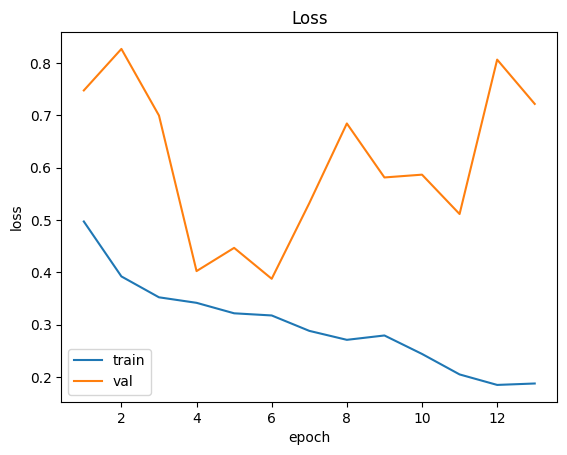

[13/19]		LR: 0.0001		Train loss: 0.188		Train acc: 59.1		Val loss: 0.722		Val acc: 45.8
Training time: 00:43:39
Stop train
Training time: 00:44:27


In [ ]:
log = {"epoch": [], "train_loss": [],  "val_loss": [], "train_acc": [], "val_acc": []}

print('Start train')

time0 = time.time()
val_loss_min = np.Inf

try:
    for epoch in range(1, config['total_epochs'] + 1):
        train_loss, train_acc = train(model, device, train_loader, criterion, optimizer)
        val_loss, val_acc = val(model, device, val_loader, criterion)

        if val_loss_min > val_loss:
            save_checkpoint(config['save_path'], model.state_dict(), epoch, 'best')
        elif epoch % config['save_epoch'] == 0:
            save_checkpoint(config['save_path'], model.state_dict(), epoch)

        log['epoch'].append(epoch)
        log['train_loss'].append(train_loss)
        log['val_loss'].append(val_loss)

        clear_output(wait=True)
        plt.plot(log['epoch'], log['train_loss'], label='train')
        plt.plot(log['epoch'], log['val_loss'], label='val')
        plt.legend()
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.title('Loss')
        plt.show()

        line = '[{}/{}]\tLR: {:.2}\tTrain loss: {:.3}\tTrain acc: {:.3}\tVal loss: {:.3}\tVal acc: {:.3}'.format(
            epoch,
            config['total_epochs'],
            get_lr(optimizer),
            train_loss,
            train_acc,
            val_loss,
            val_acc
        )
        print(line)
        print_training_time(time0, time.time())

        scheduler.step()
except KeyboardInterrupt:
    print('Training was forcibly stopped')
finally:
    print_training_time(time0, time.time())

In [ ]:
drive.flush_and_unmount()
print('All changes made in this colab session should now be visible in Drive.')

All changes made in this colab session should now be visible in Drive.


# Результаты на тестовых данных

### Загрузка модели

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model_path = "/content/drive/MyDrive/weights/43aa500a-ce74-4de3-89a9-ef03c691e1dfcheckpoint-000006.pth.tar"

state = torch.load(model_path, device)

model = WorkModel()
model.load_state_dict(state)

<All keys matched successfully>

### Загрузка датасета

In [ ]:
test_dataset = load_data(config['data_path'] + '/test', val_transform)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=0,
    pin_memory=use_gpu,
    drop_last=False
)

### Тестирование

In [ ]:
def img_display(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    npimg = np.clip(npimg, 0, 1)
    return npimg

Игнорирование warning для вывода изображений

In [ ]:
import warnings
warnings.filterwarnings("ignore")

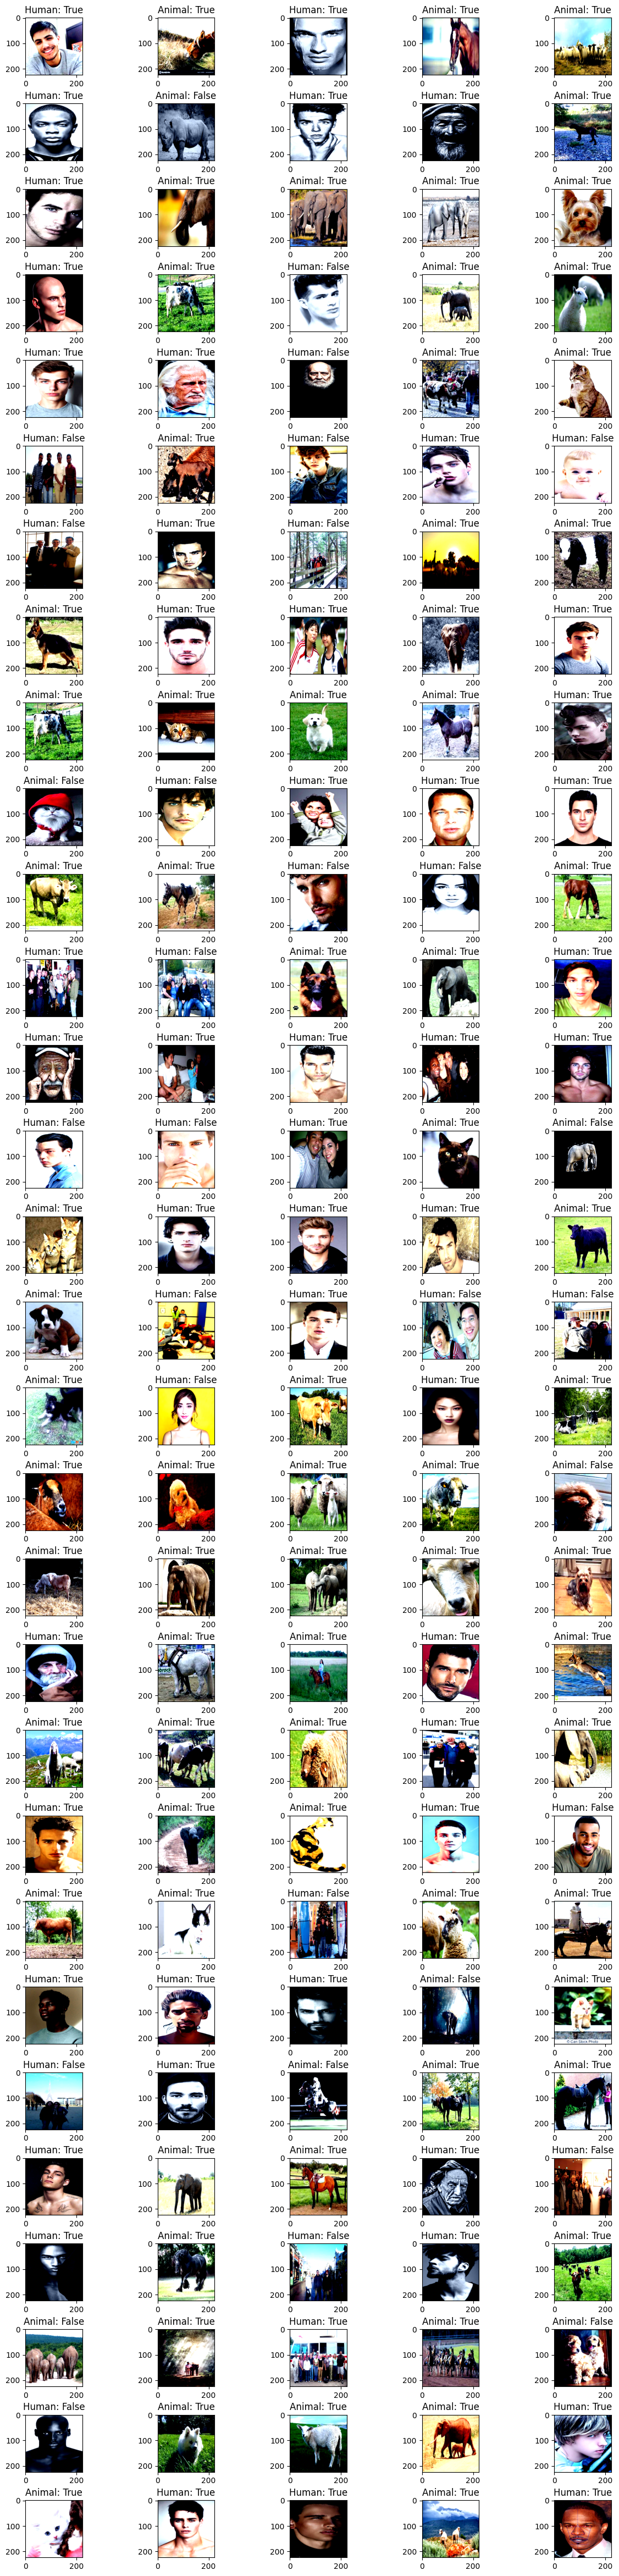

----------------------------------------------------------------------------------------------------

	Точность модели на тестовых данных: 79.33333333333333%, правильно 119/150

----------------------------------------------------------------------------------------------------


In [ ]:
classes = ['Animal', 'Human']

correct = 0
total = 0

model.eval()

fig, axis = plt.subplots(30, 5, figsize=(15, 60))

# Увеличиваем расстояние между изображениями
plt.subplots_adjust(hspace=0.5)

axis_index = 0

with torch.no_grad():
    for i, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)

        output = model(data)
        _, predicted = torch.max(output.data, 1)

        total += target.size(0)
        correct += (predicted == target).sum().item()

        for j in range(len(data)):
            ax = axis.flat[axis_index]
            ax.imshow(img_display(data[j]))
            k = target[j].item() == predicted[j].item()
            ax.set(title = f"{classes[target[j].item()]}: {k}")
            axis_index += 1

plt.show()

print('-' * 100)
print(f'\n\tТочность модели на тестовых данных: {100 * correct / total}%, правильно {correct}/{total}\n')
print('-' * 100)

*Всего тут 150 фотографий, к у каждой есть подпись: метка и значение(True/False), ошиблась модель или нет*

In [ ]:
drive.flush_and_unmount()

## Лучшие модели

**4 эпоха** - 81.33333333333333%, правильно 122/150

**6 эпоха** - 79.33333333333333%, правильно 119/150

За 40 минут прогнались 13 или 14 эпох на cpu

# Выводы

На этой неделе, а именно с 02.06.24 по 06.06.24, я погрузился в освоение новых знаний и создал свою первую нейросеть.

Я попробовал несколько разных простеньких архитектур моделей(сгенерированных нейросетью), но они были подвержены переобучению уже на первой-второй эпохе. Тогда я взял модель с туториала, она показала себя достойно.

Немалое количество времени ушло на оптимизацию процесса обучения. Сперва я хотел подавать на вход изображения размером 640x640, но в таком случае каждая эпоха бы длилась по более 5 минут. Пробовал советы нейросети увеличивал lr, ставил разные батчи, убирал слои у модели, mixed-precision, градиентный клиппинг, косинусный отжиг. Потом от всего сложного отказался. Решил фиг с ним подожду чуть подольше.

Тогда появилась новая проблема - overfitting, моя простенькая однослойная сеть не могла справиться. Добавилось пару слоев. Добавил dropout, и еще что то. Не получалось. В конце концов взял ту модель с туториала.

Оставил модель обучаться, сам ушел. Вернулся, закончился лимит на использование gpu. После этого colab больше не дает его использовать.

Такой датасет я выбрал, потому что в нем всего два класса и множество фотографий(3150 - для тренировки)

Часть кода скопировал с практики №4, но почему бы и нет :)

# Благодарности

За неоценимый вклад в работу хочу поблагодарить авторов этих статей [PyTorch-Tutorial (The Classification)](https://www.kaggle.com/code/basu369victor/pytorch-tutorial-the-classification) и [Туториал по PyTorch: от установки до готовой нейронной сети](https://neurohive.io/ru/tutorial/glubokoe-obuchenie-s-pytorch/), нейронную сеть GitHub Copilot за свои советы и помощь, VPNIFY, HitVPN за возможность пользоваться этой нейросетью, а так же создателей датасета.

# Ну и конечно же спасибо Мясникову Филиппу Сергеевичу

Благодаря этой зачетной работа, я больше не хочу иметь дело с нейросетями 😠

Шучу, мне даже понравилось